<a href="https://colab.research.google.com/github/alexandrgsv/stock_prediction_models/blob/main/%22MMVB_LSTM_ub_lb_CWB_pareto_front_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


In [2]:
# Load the data
#data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D', header=0, usecols=['<DATE>', '<CLOSE>'], date_parser=True)
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0, 
                   usecols=['<DATE>', '<CLOSE>'], 
                   parse_dates=['<DATE>'], 
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [3]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)
#df = df.set_index('<DATE>').sort_index()



In [4]:
import tensorflow.keras.backend as K

def cwbc_loss(y_true, y_pred, alpha=0.05):
    """
    Computes the Coverage Width-Based Criterion (CWBC) as a combination of the
    Prediction Interval Normalized Root-mean-square Width (PINRW) and the
    Prediction Interval Coverage Probability (PICP).

    Parameters:
        - y_true: tensor of shape (batch_size, seq_len, 1) containing the true values
        - y_pred: tensor of shape (batch_size, seq_len, 2) containing the predicted intervals
        - alpha: float, significance level for the prediction intervals (default: 0.05)

    Returns:
        - cwbc: tensor of shape (batch_size,) representing the CWBC loss
    """
    print(y_pred)
    print(y_true)
    y_lower = y_pred[:, :, 0]
    y_upper = y_pred[:, :, 1]
    y_true = K.squeeze(y_true, axis=-1)
    y_range = K.max(y_true, axis=1) - K.min(y_true, axis=1)
    interval_widths = y_upper - y_lower
    avg_widths = K.mean(interval_widths, axis=1)
    pinrw = K.sqrt(K.mean(K.square(interval_widths), axis=1)) / y_range
    picp = K.mean(K.cast(K.all(K.stack([y_true >= y_lower, y_true <= y_upper], axis=-1), axis=-1), dtype='float32'), axis=1)
    cwbc = pinrw + alpha * K.maximum(0.0, 1.0 - picp)
    return cwbc


In [5]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
#test = df[train_size-window_size:]
test = df[train_size:]

In [6]:
# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))


In [7]:
import tensorflow_probability as tfp

def coverage_loss(y_true, y_pred, width):
    q = (1 - width) / 2
    e = y_true - y_pred
    coverage = K.cast(K.abs(e) < tfp.stats.percentile(K.abs(e), q + width * 100), dtype='float32')
    coverage_error = K.mean((1 - coverage) * K.abs(e))
    prediction_error = K.mean(coverage * K.abs(e))
    return coverage_error + prediction_error


In [8]:
# Define sliding window size and stride length
window_size = 30
stride_length = 7

# Function to generate sliding windows for both training and test sets
def generate_sliding_windows(data, window_size, stride_length):
    X = []
    y_upper = []
    y_lower = []
    for i in range(0, len(data) - window_size + 1, stride_length):
        window = data[i:i+window_size]
        upper_bound = window.mean() + window.std()
        lower_bound = window.mean() - window.std()
        X.append(window)
        y_upper.append(upper_bound)
        y_lower.append(lower_bound)
    return np.array(X), np.array(y_upper), np.array(y_lower)
    
# Generate sliding windows for both training and test sets
X_train, y_train_upper, y_train_lower = generate_sliding_windows(train_scaled, window_size, stride_length)
X_test, y_test_upper, y_test_lower = generate_sliding_windows(test_scaled, window_size, stride_length)


In [9]:
# Split training data into two complementary parts
from sklearn.model_selection import train_test_split
X1_train, X2_train, y1_train_upper, y2_train_upper = train_test_split(X_train, y_train_upper, test_size=0.5)
X1_train, X2_train, y1_train_lower, y2_train_lower = train_test_split(X_train, y_train_lower, test_size=0.5)

In [19]:
np.isnan(X1_train).any()

False

In [20]:
np.isnan(X2_train).any()

False

In [ ]:
np.isnan(y1_train_upper).any()

False

In [ ]:
np.isnan(y1_train_lower).any()

False

In [ ]:
np.isnan(y2_train_upper).any()

False

In [ ]:
np.isnan(y2_train_lower).any()

False

In [10]:
# define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(window_size, 1)))
model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=0)


In [12]:
def fitness_function(params, X_train, y_train_lower, y_train_upper, X_val, y_val_lower, y_val_upper):
  lr = max(1e-5, abs(params[0]))
  batch_size = max(8, abs(int(params[1])))
  epochs = max(1, abs(int(params[2])))
  print("       Particle position is ", lr, " ", batch_size, " ", epochs, " (lr, batch_size, epochs)")
  model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
  # Train the model
  history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), np.column_stack((y_train_upper, y_train_lower)), epochs=epochs, batch_size=batch_size, callbacks = [early_stop], verbose = 0)
  #return history.history['val_loss'][-1]
  return model.evaluate(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), np.column_stack((y_val_upper, y_val_lower)), batch_size=batch_size, verbose = 0)

In [13]:
import random

# Step 1:

# Set the PSO parameters
lb = [1e-5, 16, 20]  # Lower bounds for learning rate, batch size, and epochs
ub = [1e-2, 32, 100]  # Upper bounds for learning rate, batch size, and epochs

# Number of particles and iterations
n_particles = 20
n_iterations = 6
n_dimensions = 3


# Step 2: Initialize particle swarm
class Particle:
    def __init__(self):
        self.position = np.random.uniform(low=lb, high=ub, size=(n_dimensions))
        self.velocity = np.random.uniform(low=-1*(np.array(ub)-np.array(lb)), high=np.array(ub)-np.array(lb), size=(n_dimensions))
        self.pbest_position = self.position.copy()
        self.pbest_fitness = None
        self.domination_count = 0
        self.dominated_solutions = []
        self.fitness = (0,0)

swarm = [Particle() for _ in range(n_particles)]
gbest_position = None
gbest_fitness = None

for p in swarm:
  p.fitness = (10,10)

# Step 3-6: Evaluate, update, and iterate
for i in range(n_iterations):
    print("Iteration number ", i+1, " of ", n_iterations)
    current_p = 1
    for p in swarm:
        print("     Particle number ", current_p, " of ", n_particles)
        current_p = current_p + 1
        # Evaluate fitness
        fitness1 = fitness_function(p.position, X1_train, y1_train_lower, y1_train_upper, X_test, y_test_lower, y_test_upper)
        fitness2 = fitness_function(p.position, X2_train, y2_train_lower, y2_train_upper, X_test, y_test_lower, y_test_upper)
        p.fitness = (fitness1, fitness2)

        # Update personal best
        if p.pbest_fitness is None or p.fitness < p.pbest_fitness:
            p.pbest_position = p.position.copy()
            p.pbest_fitness = p.fitness

        # Update global best
        if gbest_fitness is None or p.fitness < gbest_fitness:
            gbest_position = p.position.copy()
            gbest_fitness = p.fitness

        
        # Update velocity and position
        for j in range(n_dimensions):
            rp = random.uniform(0, 1)
            rg = random.uniform(0, 1)
            vel_cognitive = 2 * rp * (p.pbest_position[j] - p.position[j])
            vel_social = 2 * rg * (gbest_position[j] - p.position[j])
            p.velocity[j] = 0.5 * p.velocity[j] + vel_cognitive + vel_social
            p.position[j] += p.velocity[j]
    
   # Calculate domination count and dominated solutions

    for p in swarm:
      p.domination_count = 0
      p.dominated_solutions = []
      for q in swarm:
        if all(p.fitness[i] < q.fitness[i] for i in range(len(p.fitness))):
          p.dominated_solutions.append(q)
        elif all(q.fitness[i] < p.fitness[i] for i in range(len(q.fitness))):
          p.domination_count += 1

    # Step 7: Select non-dominated solutions
    pareto_front = []
    dominated_solutions = []
    for p in swarm:
        if p.domination_count == 0:
            pareto_front.append(p)
        else:
           dominated_solutions.append(p)

# Print Pareto front
for p in pareto_front:
    print(p.position, p.fitness)

Iteration number  1  of  6
     Particle number  1  of  20
       Particle position is  0.008947086491975233   19   97  (lr, batch_size, epochs)
       Particle position is  0.008947086491975233   19   97  (lr, batch_size, epochs)
     Particle number  2  of  20
       Particle position is  0.004518707391258168   26   50  (lr, batch_size, epochs)
       Particle position is  0.004518707391258168   26   50  (lr, batch_size, epochs)
     Particle number  3  of  20
       Particle position is  0.0037700292247643146   26   94  (lr, batch_size, epochs)
       Particle position is  0.0037700292247643146   26   94  (lr, batch_size, epochs)
     Particle number  4  of  20
       Particle position is  0.007254651625873665   25   37  (lr, batch_size, epochs)
       Particle position is  0.007254651625873665   25   37  (lr, batch_size, epochs)
     Particle number  5  of  20
       Particle position is  0.0086097440471671   18   63  (lr, batch_size, epochs)
       Particle position is  0.00860974

In [14]:
pareto_front_fitness = []
dominated_solutions_fitness = []

for p in pareto_front:
    pareto_front_fitness.append(p.fitness)

for q in dominated_solutions:
    dominated_solutions_fitness.append(q.fitness)

print(pareto_front_fitness)
print(dominated_solutions_fitness)

[(0.13127583265304565, 0.16583555936813354), (0.13793861865997314, 0.15707999467849731), (0.14354319870471954, 0.14884550869464874), (0.14177486300468445, 0.1533840298652649), (0.1457844376564026, 0.1330329328775406)]
[(0.142700657248497, 0.16720451414585114), (0.18601751327514648, 0.13777956366539001), (0.1566750407218933, 0.18981653451919556), (0.17731910943984985, 0.17907725274562836), (0.13584116101264954, 0.1715044379234314), (0.15260161459445953, 0.17186731100082397), (0.13309624791145325, 0.16704398393630981), (0.13900457322597504, 0.16549928486347198), (0.14260931313037872, 0.16511739790439606), (0.14885984361171722, 0.17015030980110168), (0.14994360506534576, 0.16259226202964783), (0.15920600295066833, 0.15990011394023895), (0.23392219841480255, 0.23171700537204742), (0.19400137662887573, 0.21662607789039612), (0.21805500984191895, 0.21811822056770325)]


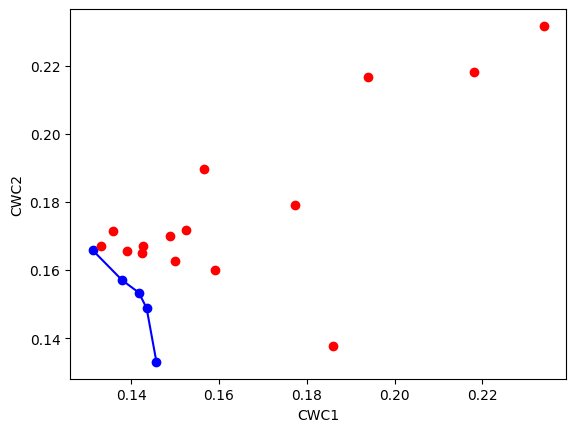

In [18]:
# sort the pareto front by x-coordinate
pareto_front_fitness.sort(key=lambda p: p[0])

# extract the sorted x and y coordinates from the tuples
x = [p[0] for p in pareto_front_fitness]
y = [p[1] for p in pareto_front_fitness]

# extract the sorted x and y coordinates from the tuples of dominated solutions
x_dom = [p[0] for p in dominated_solutions_fitness]
y_dom = [p[1] for p in dominated_solutions_fitness]

# create a line plot with dots at each point on the x and y coordinates
plt.plot(x, y, 'o-', color='blue')
plt.plot(x_dom, y_dom, 'o', color='red', linestyle='None')

# set the labels for the x and y axes
plt.xlabel('CWC1')
plt.ylabel('CWC2')

# show the plot
plt.show()

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

5/5 [==============================] - 0s 7ms/step


In [ ]:
np.mean(y_test)

In [ ]:
np.std(y_test)

ValueError: ignored

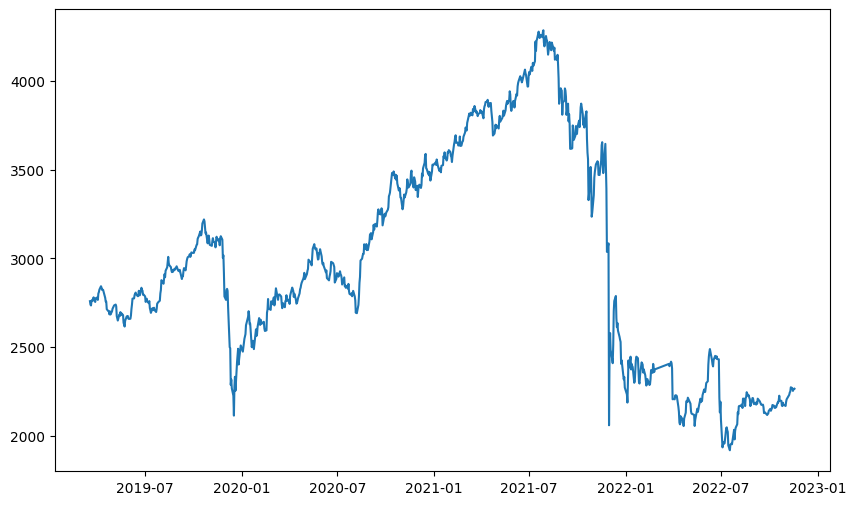

In [ ]:
# Plot the actual and predicted stock prices with the upper and lower bounds
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test['<DATE>'][:-forecast_horizon-60], y_test[:, 0], label='Actual')
ax.plot(test['<DATE>'][:-forecast_horizon-60], y_pred[:, 0], label='Predicted')
ax.fill_between(test['<DATE>'][:-forecast_horizon-60], y_pred[:, 0], y_pred[:, 1], alpha=0.7, label='LB-UB Interval')
ax.legend()
plt.show()


In [ ]:
# the interval width
plt.plot(y_pred[::forecast_horizon, 1]-y_pred[::forecast_horizon, 0])

In [ ]:
# Create the training data using the sliding window approach for all the data available
train_scaled = scaler.fit_transform(df['<CLOSE>'].values.reshape(-1, 1))

X_train = []
y_train = []
for i in range(window_size, len(train_scaled)):
    X_train.append(train_scaled[i-window_size:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

In [ ]:
last_window_forecast = scaler.inverse_transform(model.predict(X_test[-window_size].reshape(-1,1)))

In [ ]:
plt.plot(last_window_forecast[1])

In [ ]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

start_date = test['<DATE>'].iloc[-1].date()
N = 10 # replace with the number of dates you want to generate

dates = []
for i in range(N):
    date = start_date + datetime.timedelta(days=i)
    day = date.weekday()
    if day < 5: # Add only weekdays
        dates.append(date)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(dates, last_window_forecast[1,:len(dates)], last_window_forecast[0, :len(dates)], alpha=1, label='LB-UB Interval Forecast')
# filter out weekends from dates list
weekdays = [date for date in dates if date.weekday() < 5]
weekdays_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(weekdays_fmt)
ax.set_xticks(weekdays)

# rotate the x-axis tick labels
plt.xticks(rotation=90)
ax.legend()
plt.show()
